In [1]:
!nvidia-smi

Wed Mar 16 18:08:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8    26W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from random import randint
import time
import os
import glob
import pandas as pd

In [6]:
df = pd.read_csv('/content/drive/MyDrive/MLStuff/Datasets/Seismic_data/FileNames_And_Classes_Train.csv',index_col=0)

In [7]:
df

,filename,class
0,2020-07-24 13_38_04-download (8) - Windows Pho...,anticline
1,2020-07-24 13_42_15-download (11) - Windows Ph...,anticline
2,2020-07-24 13_42_49-download (11) - Windows Ph...,anticline
3,2020-07-24 13_36_54-download (6) - Windows Pho...,anticline
4,2020-07-24 13_27_19-anticline - Windows Photo ...,anticline
...,...,...
233,2020-07-24 22_10_15-images (17) - Windows Phot...,salt
234,2020-07-24 22_11_17-images (20) - Windows Phot...,salt
235,2020-07-24 22_03_09-download - Windows Photo V...,salt
236,2020-07-24 22_05_06-images (3) - Windows Photo...,salt


In [8]:
df['class'].value_counts()

fault        74
salt         72
anticline    60
syncline     32
Name: class, dtype: int64

In [10]:
filename = df['filename'].to_list()

In [14]:
import glob
import cv2
X = []
files = '/content/drive/MyDrive/MLStuff/Datasets/Seismic_data/All_Train/'
for myfile in filename:
    image = cv2.imread(files+myfile)
    print(myfile)
    #image = cv2.resize(image, (128,128))
    X.append(image)

2020-07-24 13_38_04-download (8) - Windows Photo Viewer.jpg
2020-07-24 13_42_15-download (11) - Windows Photo Viewer.jpg
2020-07-24 13_42_49-download (11) - Windows Photo Viewer.jpg
2020-07-24 13_36_54-download (6) - Windows Photo Viewer.jpg
2020-07-24 13_27_19-anticline - Windows Photo Viewer.jpg
2020-07-24 13_46_59-FlatSpotPickthis1 - Windows Photo Viewer.jpg
2020-07-24 13_36_11-download (6) - Windows Photo Viewer.jpg
2020-07-24 13_32_50-download (4) - Windows Photo Viewer.jpg
2020-07-24 13_34_28-download (5) - Windows Photo Viewer.jpg
2020-07-24 13_47_31-images (1) - Windows Photo Viewer.jpg
2020-07-24 13_39_55-download (9) - Windows Photo Viewer.jpg
2020-07-24 13_47_41-images (1) - Windows Photo Viewer.jpg
2020-07-24 13_33_51-download (5) - Windows Photo Viewer.jpg
2020-07-24 13_25_06-anticline - Windows Photo Viewer.jpg
2020-07-24 13_41_13-download (10) - Windows Photo Viewer.jpg
2020-07-24 13_11_49-anticline - Windows Photo Viewer.jpg
2020-07-24 13_33_35-download (5) - Windows Ph

In [15]:
x = np.asarray(X)

In [16]:
x.shape

(238, 164, 128, 3)

In [18]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()

df['class'] = labelencoder.fit_transform(df['class'])

In [19]:
df['class'].value_counts()

1    74
2    72
0    60
3    32
Name: class, dtype: int64

In [20]:
arr = []
for i in df['class']:
    arr.append([i])

In [21]:
y = np.asarray(arr)

In [24]:
def one_hot(y):
    n_values = np.max(y) + 1
    y_new = np.eye(n_values)[y[:,0]]
    return y_new

In [25]:
y = one_hot(y)

In [27]:
x.shape,y.shape

((238, 164, 128, 3), (238, 4))

In [28]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [29]:
base_model = tf.keras.applications.resnet50.ResNet50(weights= 'imagenet', include_top=False)


94781440/94765736 [==============================] - 1s 0us/step


In [43]:
dropout_rate = 0.5
model_f = tf.keras.models.Sequential()
model_f.add(base_model)
model_f.add(tf.keras.layers.GlobalMaxPooling2D(name="gap"))
if dropout_rate > 0:
    model_f.add(tf.keras.layers.Dropout(dropout_rate, name="dropout_out"))
model_f.add(tf.keras.layers.Dense(4, activation='softmax', name="fc_out"))

In [44]:
model_f.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 gap (GlobalMaxPooling2D)    (None, 2048)              0         
                                                                 
 dropout_out (Dropout)       (None, 2048)              0         
                                                                 
 fc_out (Dense)              (None, 4)                 8196      
                                                                 
Total params: 23,595,908
Trainable params: 23,542,788
Non-trainable params: 53,120
_________________________________________________________________


In [45]:
import tensorflow as tf
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import classification_report 

class MetricsCallback(Callback):
    def __init__(self, train_data, y_true_train,test_data,y_true_test):
        # Should be the label encoding of your classes
        self.train_data = train_data
        self.test_data = test_data
        self.y_true_train = y_true_train
        self.y_true_test = y_true_test
        #self.model_name = model_name
        
    def on_epoch_end(self, epoch, logs=None):
        # Here we get the probabilities
        y_pred_train = self.model.predict(self.train_data)
        # Here we get the actual classes
        y_pred_train = tf.argmax(y_pred_train,axis=1)
        
        y_pred_test = self.model.predict(self.test_data)
       
        y_pred_test = tf.argmax(y_pred_test,axis=1)
        
        y_true_train_c = tf.argmax(self.y_true_train,axis = 1)
        y_true_test_c = tf.argmax(self.y_true_test,axis = 1)
        
        # Actual dictionary
        report_dictionary_train = classification_report(y_true_train_c, y_pred_train, output_dict = True)
        report_dictionary_test = classification_report(y_true_test_c, y_pred_test, output_dict = True)
        
        #df_t = pd.DataFrame(classification_report(y_true_train_c, y_pred_train, output_dict = True)).T
        #df_v = pd.DataFrame(classification_report(y_true_test_c, y_pred_test, output_dict = True)).T
        
        #df_t.to_csv('training score'+"_"+str(epoch)+'.csv')
        #df_v.to_csv('validation score'+"_"+str(epoch)+'.csv')
                            

        # Only printing the report
        print(classification_report(y_true_train_c, y_pred_train, output_dict = False))
        print(classification_report(y_true_test_c, y_pred_test, output_dict = False))  

In [46]:
model_f.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

from tensorflow.keras import callbacks

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


#earlystopping = callbacks.EarlyStopping(monitor ="val_loss", mode ="min", patience = 20, restore_best_weights = True,verbose=1)
model_checkpoint = ModelCheckpoint('Fine_classifier.h5', verbose=1, save_best_only=True)

#metrics_callback = MetricsCallback(train_data=x_train,y_true_train=y_train,test_data=x_test,y_true_test=y_test)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [47]:
n_folds=1

epochs=20
batch_size=8

In [48]:
def fit_and_evaluate(t_x, val_x, t_y, val_y, EPOCHS=1000, BATCH_SIZE=8):
    model = model_f
    results = model.fit(t_x, t_y, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[model_checkpoint,MetricsCallback(train_data=t_x,y_true_train=t_y,test_data=val_x,y_true_test=val_y)],verbose=1, validation_split=0.2)  
    print("Val Score: ", model.evaluate(val_x, val_y))
    return results

In [49]:
#save the model history in a list after fitting so that we can plot later
model_history = [] 

for i in range(n_folds):
    print("Training on Fold: ",i+1)
    t_x, val_x, t_y, val_y = train_test_split(x, y, test_size=0.2,random_state = np.random.randint(1,1000, 1)[0])
    model_history.append(fit_and_evaluate(t_x, val_x, t_y, val_y, epochs, batch_size))
    print("======="*12, end="\n\n\n")

Training on Fold:  1
Epoch 1/20
19/19 [==============================] - ETA: 0s - loss: 6.8058 - accuracy: 0.3882
Epoch 1: val_loss improved from inf to 3.97023, saving model to Fine_classifier.h5
              precision    recall  f1-score   support

           0       0.44      0.81      0.57        47
           1       0.84      0.27      0.41        60
           2       0.58      0.84      0.69        56
           3       1.00      0.15      0.26        27

    accuracy                           0.55       190
   macro avg       0.72      0.52      0.48       190
weighted avg       0.69      0.55      0.51       190

              precision    recall  f1-score   support

           0       0.32      0.54      0.40        13
           1       1.00      0.14      0.25        14
           2       0.54      0.81      0.65        16
           3       0.00      0.00      0.00         5

    accuracy                           0.46        48
   macro avg       0.46      0.37      0.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

19/19 [==============================] - ETA: 0s - loss: 1.5246 - accuracy: 0.7961
Epoch 2: val_loss improved from 3.97023 to 2.81908, saving model to Fine_classifier.h5
              precision    recall  f1-score   support

           0       0.72      0.87      0.79        47
           1       0.88      0.72      0.79        60
           2       0.67      0.95      0.79        56
           3       1.00      0.19      0.31        27

    accuracy                           0.75       190
   macro avg       0.82      0.68      0.67       190
weighted avg       0.79      0.75      0.72       190

              precision    recall  f1-score   support

           0       0.62      0.62      0.62        13
           1       0.73      0.57      0.64        14
           2       0.58      0.88      0.70        16
           3       0.00      0.00      0.00         5

    accuracy                           0.62        48
   macro avg       0.48      0.52      0.49        48
weighted avg   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

19/19 [==============================] - ETA: 0s - loss: 1.2709 - accuracy: 0.8026
Epoch 3: val_loss improved from 2.81908 to 2.28740, saving model to Fine_classifier.h5
              precision    recall  f1-score   support

           0       0.85      0.85      0.85        47
           1       0.96      0.78      0.86        60
           2       0.68      0.98      0.80        56
           3       0.92      0.44      0.60        27

    accuracy                           0.81       190
   macro avg       0.85      0.77      0.78       190
weighted avg       0.84      0.81      0.80       190

              precision    recall  f1-score   support

           0       0.79      0.85      0.81        13
           1       0.91      0.71      0.80        14
           2       0.65      0.94      0.77        16
           3       0.00      0.00      0.00         5

    accuracy                           0.75        48
   macro avg       0.59      0.62      0.60        48
weighted avg   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

19/19 [==============================] - ETA: 0s - loss: 1.1096 - accuracy: 0.8684
Epoch 4: val_loss did not improve from 2.28740
              precision    recall  f1-score   support

           0       0.86      0.91      0.89        47
           1       1.00      0.75      0.86        60
           2       0.74      1.00      0.85        56
           3       0.89      0.63      0.74        27

    accuracy                           0.85       190
   macro avg       0.87      0.82      0.83       190
weighted avg       0.87      0.85      0.85       190

              precision    recall  f1-score   support

           0       0.91      0.77      0.83        13
           1       1.00      0.57      0.73        14
           2       0.59      1.00      0.74        16
           3       0.50      0.20      0.29         5

    accuracy                           0.73        48
   macro avg       0.75      0.64      0.65        48
weighted avg       0.79      0.73      0.72        48



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

19/19 [==============================] - ETA: 0s - loss: 0.5004 - accuracy: 0.9145
Epoch 10: val_loss did not improve from 2.18938
              precision    recall  f1-score   support

           0       0.88      0.98      0.93        47
           1       0.94      0.97      0.95        60
           2       0.98      0.93      0.95        56
           3       1.00      0.85      0.92        27

    accuracy                           0.94       190
   macro avg       0.95      0.93      0.94       190
weighted avg       0.95      0.94      0.94       190

              precision    recall  f1-score   support

           0       0.85      0.85      0.85        13
           1       0.86      0.86      0.86        14
           2       0.94      1.00      0.97        16
           3       0.75      0.60      0.67         5

    accuracy                           0.88        48
   macro avg       0.85      0.83      0.83        48
weighted avg       0.87      0.88      0.87        48


In [50]:
model_history[0].history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [51]:
df = pd.DataFrame()
for i in model_history[0].history.keys():
  df[i] = model_history[0].history[i]

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc24af89c10>,
      dtype=object)

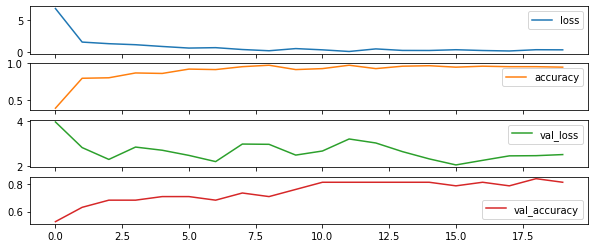

In [52]:
df.plot(subplots = True,figsize = (10,4))

In [53]:
df.to_csv('/content/drive/MyDrive/MLStuff/Datasets/Seismic_data/history_resnet.csv')

In [54]:
i = cv2.imread('/content/drive/MyDrive/MLStuff/Datasets/Seismic_data/val_reshaped/anticline/2020-07-24 13_49_23-images (4) - Windows Photo Viewer.jpg')

In [57]:
i.shape

(164, 128, 3)

In [58]:
i = i.reshape(1,164, 128, 3)

In [60]:
pr = model_f.predict(i)

In [61]:
p = np.argmax(pr)

In [62]:
p

0

In [64]:
di = {'anticline':0,'fault':1,'salt':2,'syncline':3}

In [66]:
dic = {0:'anticline',1:'fault',2:'salt',3:'syncline'}

In [69]:
dic[p]

'anticline'

In [78]:
def final_predictor(model,img):
  im = cv2.imread(img)
  im = cv2.resize(im,(128,164))
  i =im.reshape(1,164, 128, 3)
  pr = model.predict(i)
  p = np.argmax(pr)
  plt.imshow(im)
  plt.title(f'{dic[p]}')
  return dic[p]




'anticline'

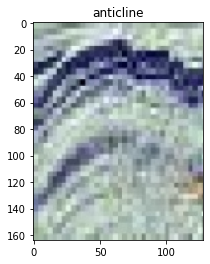

In [80]:
final_predictor(model_f,'/content/drive/MyDrive/MLStuff/Datasets/Seismic_data/val_reshaped/anticline/2020-07-24 13_49_23-images (4) - Windows Photo Viewer.jpg')

In [81]:
model_load = tf.keras.models.load_model("/content/drive/MyDrive/MLStuff/Datasets/Seismic_data/models/Fine_classifier_resnet_1st.h5")

'anticline'

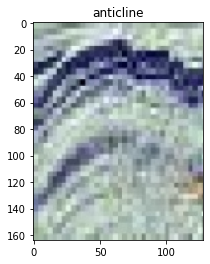

In [82]:
final_predictor(model_load,'/content/drive/MyDrive/MLStuff/Datasets/Seismic_data/val_reshaped/anticline/2020-07-24 13_49_23-images (4) - Windows Photo Viewer.jpg')